In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 

from sklearn.model_selection import StratifiedKFold


import os,glob
from src.baseline import baseline_model, evalulate_model_accuracy, cramers_v
from src.baseline.preprocess_data import down_sampling, remove_outliers

In [ ]:
def split_data(data_csv, features):
    train_data   = data_csv[features].drop(columns = ['diagnosed_diabetes'])
    train_target = data_csv['diagnosed_diabetes']

    train_data, test_data, train_target, test_target = train_test_split(train_data, train_target, test_size=0.2, random_state=8964)

    return train_data, test_data, train_target, test_target

In [ ]:
project_dir = os.getcwd()
data_dir = os.path.join(project_dir, 'data')

data_csv = pd.read_csv(os.path.join(data_dir, 'train.csv'))
# test_csv = pd.read_csv(os.path.join(data_dir, 'test.csv'))

data_csv = data_csv.drop(columns=['id']) 
# data_csv, _ = remove_outliers(data_csv, verbose=True)

In [4]:
print(data_csv.columns)

Index(['age', 'alcohol_consumption_per_week',
       'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
       'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
       'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol',
       'triglycerides', 'gender', 'ethnicity', 'education_level',
       'income_level', 'smoking_status', 'employment_status',
       'family_history_diabetes', 'hypertension_history',
       'cardiovascular_history', 'diagnosed_diabetes'],
      dtype='object')


In [ ]:
# data_csv = down_sampling(data_csv)

diagnosed_diabetes
1.0    263693
0.0    263693
Name: count, dtype: int64


<Axes: >

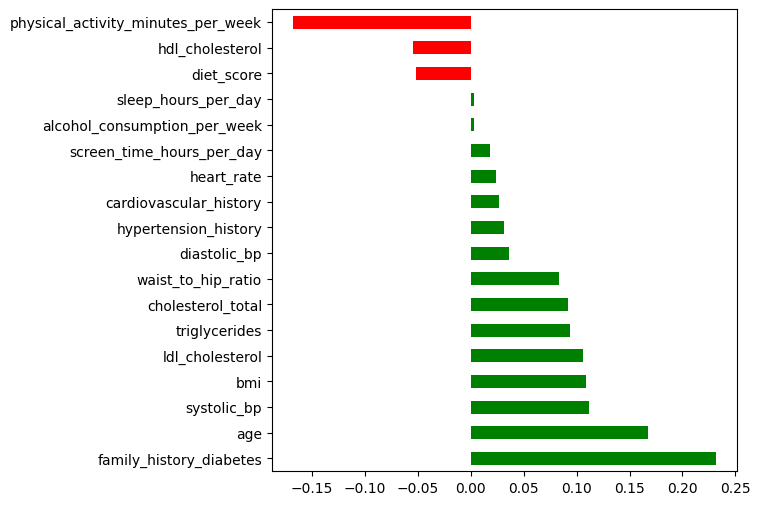

In [6]:
numerical_data  = data_csv.select_dtypes(include=[np.number])
corr_matrix     = numerical_data.corr()

fig, ax = plt.subplots(figsize=(10, 10)) 
diabetes_corr = corr_matrix['diagnosed_diabetes'].drop('diagnosed_diabetes').sort_values(ascending=False)

colors = ['green' if x > 0 else 'red' for x in diabetes_corr]
diabetes_corr.plot(kind='barh', color=colors, figsize=(6, 6)) 

In [ ]:
def clinical_features(df_raw):

    df = df_raw.copy()

    ### Risk Factors ###

    df['high_triglycerides'] = (df['triglycerides'] > 150).astype(int)

    df['low_hdl'] = (df['hdl_cholesterol'] < 35).astype(int)
    
    df['high_triglycerides'] = (df['triglycerides'] > 250).astype(int)

    df['hypertension'] = (
        (df['systolic_bp'] >= 130) | (df['diastolic_bp'] >= 80)
    ).astype(int)

    df['physically_inactive'] = ( df['physical_activity_minutes_per_week'] < 100).astype(int)

    df['age_risk_35'] = (df['age'] > 35).astype(int)

    df['high_bmi'] = (df['bmi'] >= 25).astype(int)

    df['obesity'] = (df['bmi'] >= 30).astype(int)

    df['uber_obesity'] = (df['bmi'] >= 35).astype(int)

    df['if_male'] = (df['gender'] == 'Male').astype(int)

    df['ada_risk_factor_count'] = (
        df['age_risk_35']  
        +  df['high_bmi'] + df['obesity'] + df['uber_obesity']
        + df['physically_inactive'] 
        + df['hypertension']
        + df['low_hdl'] 
        + df['high_triglycerides']
        + df['family_history_diabetes'] 
        + df['hypertension_history']  
        + df['cardiovascular_history'] 
        + df['if_male']
        )
    

    df['bp_normal'] = (
        (df['systolic_bp'] < 120) & 
        (df['diastolic_bp'] < 80) ).astype(int)

    # LIFE STYLE
    
    df['poor_diet'] = (df['diet_score'] < 5).astype(int)
    df['insufficient_sleep'] = (df['sleep_hours_per_day'] < 7).astype(int)
    df['excessive_screen_time'] = (df['screen_time_hours_per_day'] > 6).astype(int)
    df['high_alcohol'] = (df['alcohol_consumption_per_week'] > 7).astype(int)  # > 7 drinks/week
 
    df['toxic_lifestyle'] = (
        df['poor_diet'] +
        df['insufficient_sleep'] +
        df['excessive_screen_time'] +
        df['high_alcohol'] +
        df['physically_inactive']
    )
     
    # INTERACTION OF FEATURES

    df['bp_age'] = df['age'] * df['systolic_bp']
    df['bp_bmi'] = df['bmi'] * df['systolic_bp']
    df['bp_age_bmi'] = df['age'] * df['bmi'] * df['systolic_bp']

    df['triglycerides_hdl_cholesterol'] = df['triglycerides']/ df['hdl_cholesterol']
    df['mets-ir'] = df['triglycerides_hdl_cholesterol'] * df['bmi']
    df['mets-ir_age'] =  df['mets-ir'] * df['age']
    
    df['bmi_exercise'] = df['bmi'] * (1 + df['physical_activity_minutes_per_week'] / 100)
    df['age_bmi'] = df['age'] * df['bmi']
    df['age_bmi_exercise'] = df['age'] * df['bmi'] * (1 + df['physical_activity_minutes_per_week'] / 100)

    df['age_family_history'] = df['age'] * df['family_history_diabetes']
    df['bmi_family_history'] = df['bmi'] * df['family_history_diabetes']
    df['age_bmi_family_history'] = df['age'] * df['bmi'] * df['family_history_diabetes']
    


    # cardiovascular burden 
    df['cardio_comorbidity_count'] = (
        df['hypertension_history'] +
        df['cardiovascular_history'] +
        df['family_history_diabetes']
    )

    return df
    
data_csv2 = clinical_features(data_csv)

<Axes: >

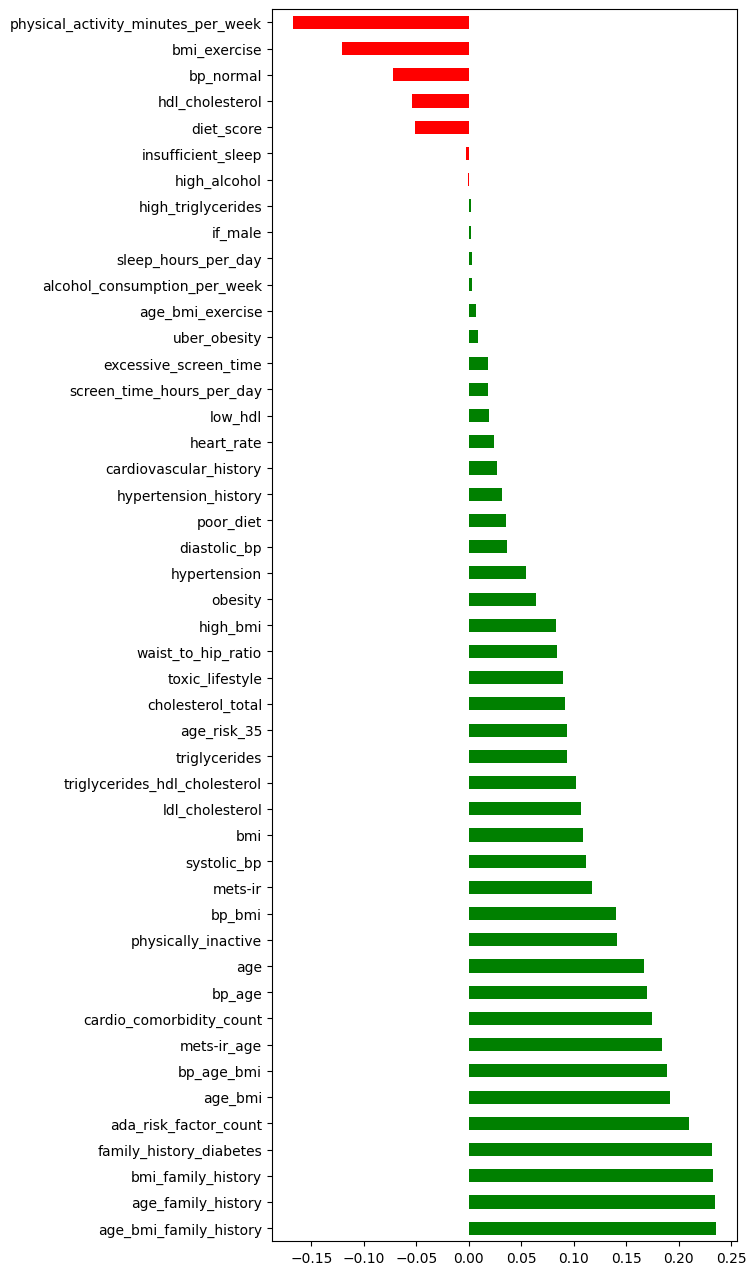

In [8]:
num_cols = data_csv2.select_dtypes(include=[np.number]).columns

corr_matrix = data_csv2[num_cols].corr()

diabetes_corr = corr_matrix['diagnosed_diabetes'].drop('diagnosed_diabetes').sort_values(ascending=False)

colors = ['green' if x > 0 else 'red' for x in diabetes_corr]
diabetes_corr.plot(kind='barh', color=colors, figsize=(6, 16)) 


In [35]:
data_csv2['diagnosed_diabetes'].value_counts()

diagnosed_diabetes
1.0    263693
0.0    263693
Name: count, dtype: int64

In [36]:
nfeat2          = data_csv2.select_dtypes(include=[np.number]).columns.tolist(); print(nfeat2)
numerical_data  = data_csv2.select_dtypes(include=[np.number]); print(len(numerical_data.columns))

signfiicant_features = corr_matrix['diagnosed_diabetes'].abs().sort_values(ascending=False)[:20].index.tolist(); print(len(signfiicant_features))
log_clf, rf_clf = baseline_model(numerical_data, signfiicant_features, random_state=8964)
train_data, valid_data, train_target, valid_target = split_data(numerical_data, signfiicant_features)
evalulate_model_accuracy(log_clf, rf_clf, valid_data, valid_target)


['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes', 'high_triglycerides', 'low_hdl', 'hypertension', 'physically_inactive', 'age_risk_45', 'bmi_overweight', 'ada_risk_factor_count', 'bp_normal', 'bp_hypertension', 'poor_diet', 'insufficient_sleep', 'excessive_screen_time', 'high_alcohol', 'lifestyle_risk_score', 'bp_age', 'bp_bmi', 'bp_age_bmi', 'triglycerides_hdl_cholesterol', 'mets-ir', 'mets-ir_age', 'bmi_exercise', 'age_bmi', 'age_bmi_exercise', 'age_family_history', 'bmi_family_history', 'age_bmi_family_history', 'cardio_comorbidity_count', 'unhealthy_lifestyle_cluster']
47
20


/Users/k.choi/Documents/github/diabetes-diagonsis/stats_tools/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.635137185005404
RandomForestClassifier 0.6404463490016875
Accuracy:  LogisticRegression 0.635137185005404
ROC-AUC :  LogisticRegression 0.6922761640171938
Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.69      0.66     52896
         1.0       0.65      0.58      0.61     52582

    accuracy                           0.64    105478
   macro avg       0.64      0.63      0.63    105478
weighted avg       0.64      0.64      0.63    105478

Confusion Matrix:
[[36569 16327]
 [22158 30424]]
Accuracy:  RandomForestClassifier 0.6404463490016875
ROC-AUC :  RandomForestClassifier 0.6980647857206775
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.69      0.66     52896
         1.0       0.66      0.59      0.62     52582

    accuracy                           0.64    105478
   macro avg       0.64      0.64      0.64    105478
weighted avg       0.64 

In [37]:
nfeat1          = data_csv.select_dtypes(include=[np.number]).columns.tolist(); print(nfeat1); print(len(nfeat1))
numerical_data1 = data_csv.select_dtypes(include=[np.number]); print(len(numerical_data1.columns))

log_clf, rf_clf = baseline_model(numerical_data1, nfeat1, random_state=8964)

train_data, valid_data, train_target, valid_target = split_data(numerical_data1, nfeat1)
evalulate_model_accuracy(log_clf, rf_clf, valid_data, valid_target)

['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes']
19
19


/Users/k.choi/Documents/github/diabetes-diagonsis/stats_tools/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.63805722520336
RandomForestClassifier 0.6415176624509377
Accuracy:  LogisticRegression 0.63805722520336
ROC-AUC :  LogisticRegression 0.6945871056512246
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.68      0.65     52896
         1.0       0.65      0.60      0.62     52582

    accuracy                           0.64    105478
   macro avg       0.64      0.64      0.64    105478
weighted avg       0.64      0.64      0.64    105478

Confusion Matrix:
[[35983 16913]
 [21264 31318]]
Accuracy:  RandomForestClassifier 0.6415176624509377
ROC-AUC :  RandomForestClassifier 0.6990274109044052
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.70      0.66     52896
         1.0       0.66      0.58      0.62     52582

    accuracy                           0.64    105478
   macro avg       0.64      0.64      0.64    105478
weighted avg       0.64   